# 🦕 Dinosaur Footprint Classifier Pipeline

**This notebook contains the full pipeline for classifying dinosaur footprints:**
1. Setup & Configuration
2. Data Loading & Mapping
3. Data Exploration
4. Data Preprocessing & Augmentation
5. Model Building
6. Training
7. Evaluation & Results

**Data source:** DinoTracker dataset (NPZ + Excel format)

**Classes (3 dinosaur groups):** Ornithopoda, Stegosauria, Theropoda

---
## 1. Setup & Configuration

In [13]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import openpyxl
import os
import unicodedata

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU available: []


In [14]:
# ============================================
# CONFIGURATION
# ============================================

# Data paths
DATA_DIR = os.path.join(os.getcwd(), 'data')
IMAGES_FILE = os.path.join(DATA_DIR, 'images_compressed.npz')
NAMES_FILE = os.path.join(DATA_DIR, 'names.npy')
TRACKS_FILE = os.path.join(DATA_DIR, 'tracks.xlsx')

# Model settings
IMG_SIZE = (100, 100)    # Native resolution of dino images
BATCH_SIZE = 32          # Images per batch
EPOCHS = 100             # Maximum training epochs
TEST_SPLIT = 0.15        # 15% for testing
VAL_SPLIT = 0.15         # 15% for validation (from remaining)

# Select only the 3 most relevant dinosaur groups
SELECTED_CLASSES = ['Ornithopoda', 'Stegosauria', 'Theropoda']

# Output paths
MODEL_DIR = os.path.join(os.getcwd(), 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"{'='*50}")
print(f"CONFIGURATION")
print(f"{'='*50}")
print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}")
print(f"Selected classes: {SELECTED_CLASSES}")
print(f"Data directory: {DATA_DIR}")
print(f"Model directory: {MODEL_DIR}")

CONFIGURATION
Image size: (100, 100)
Batch size: 32
Max epochs: 100
Selected classes: ['Ornithopoda', 'Stegosauria', 'Theropoda']
Data directory: c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\Footprint_Classification_Project\just one more thing!\data
Model directory: c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\Footprint_Classification_Project\just one more thing!\models


---
## 2. Data Loading & Label Mapping

The DinoTracker data consists of:
- `images_compressed.npz` → 1949 grayscale images (100×100)
- `names.npy` → Filenames corresponding to each image
- `tracks.xlsx` → Metadata including the **Group** column (classification label)

We map each image to its class label by matching filenames to the Excel data,
then filter to keep only the 5 selected dinosaur groups.

In [15]:
# ============================================
# LOAD RAW DATA
# ============================================

# Load images
with np.load(IMAGES_FILE) as data:
    images = data['images']
print(f"Loaded {images.shape[0]} images, shape: {images.shape[1:]}")
print(f"Image dtype: {images.dtype}, range: [{images.min():.4f}, {images.max():.4f}]")

# Load names
names = np.load(NAMES_FILE, allow_pickle=True)
print(f"Loaded {len(names)} image names")

# Load tracks from Excel
wb = openpyxl.load_workbook(TRACKS_FILE)
ws = wb.active
print(f"Loaded tracks: {ws.max_row - 1} entries")
print(f"Columns: {[c.value for c in ws[1]]}")

Loaded 1949 images, shape: (100, 100)
Image dtype: float64, range: [0.0000, 1.0000]
Loaded 1949 image names
Loaded tracks: 1976 entries
Columns: ['ID', 'Group', 'Reference', 'Ichnotaxon or species name', 'Period', 'Fig. No.', 'Additional information']


In [16]:
# ============================================
# MAP IMAGES TO CLASS LABELS
# ============================================

def normalize_for_matching(s):
    """Normalize a string for fuzzy matching between names.npy and tracks.xlsx."""
    s = str(s).strip().lower()
    # Normalize unicode characters (handle accented chars like García, Díaz)
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('ascii')
    return s

# Build lookup dictionaries from tracks.xlsx
# The ID column format varies: 'Author_Year Number' with spaces or underscores
id_to_group_underscore = {}  # Keys with spaces replaced by underscores
id_to_group_original = {}    # Keys with original spacing

for row in ws.iter_rows(min_row=2):
    if row[0].value is not None:
        track_id = str(row[0].value).strip()
        group = str(row[1].value).strip() if row[1].value else None
        if group is None or group == 'None':
            continue
        
        # Normalize and store with underscore variant
        norm_id = normalize_for_matching(track_id)
        id_to_group_original[norm_id] = group
        id_to_group_underscore[norm_id.replace(' ', '_')] = group

# Match each image name to a class label
matched_images = []
matched_labels = []
unmatched = []

for i, name in enumerate(names):
    name_str = str(name).strip()
    name_norm = normalize_for_matching(name_str).replace('.png', '')
    
    # Try multiple matching strategies
    group = None
    
    # Strategy 1: Direct match (underscore format)
    if name_norm in id_to_group_underscore:
        group = id_to_group_underscore[name_norm]
    # Strategy 2: Match with original spacing
    elif name_norm in id_to_group_original:
        group = id_to_group_original[name_norm]
    # Strategy 3: Replace underscores with spaces
    elif name_norm.replace('_', ' ') in id_to_group_original:
        group = id_to_group_original[name_norm.replace('_', ' ')]
    
    if group is not None:
        matched_images.append(i)
        matched_labels.append(group)
    else:
        unmatched.append(name_str)

print(f"\n{'='*50}")
print(f"LABEL MAPPING RESULTS")
print(f"{'='*50}")
print(f"Total images: {len(names)}")
print(f"Matched: {len(matched_images)} ({100*len(matched_images)/len(names):.1f}%)")
print(f"Unmatched: {len(unmatched)}")
if unmatched:
    print(f"\nUnmatched names (excluded from training):")
    for n in unmatched[:10]:
        print(f"  - {n}")
    if len(unmatched) > 10:
        print(f"  ... and {len(unmatched) - 10} more")


LABEL MAPPING RESULTS
Total images: 1949
Matched: 1936 (99.3%)
Unmatched: 13

Unmatched names (excluded from training):
  - fiorillo_2021_1.png
  - lallensack_2022_pizza_rockfall_08.png
  - lallensack_2022_pizza_rockfall_09.png
  - lallensack_2022_pizza_rockfall_04.png
  - lallensack_2022_pizza_rockfall_05.png
  - lallensack_2022_pizza_rockfall_07.png
  - lallensack_2022_pizza_rockfall_06.png
  - lallensack_2022_Copper_Ridge_1.png
  - lallensack_2022_pizza_rockfall_02.png
  - lallensack_2022_pizza_rockfall_03.png
  ... and 3 more


In [17]:
# ============================================
# PREPARE FINAL DATASET
# ============================================

# Extract matched images and labels
X_all = images[matched_images]  # shape: (N, 100, 100)
y_all = np.array(matched_labels)

# Filter to only the 5 selected dinosaur classes
mask = np.isin(y_all, SELECTED_CLASSES)
X = X_all[mask]
y_raw = y_all[mask]
excluded_count = len(y_all) - mask.sum()
print(f"Filtered to {SELECTED_CLASSES}")
print(f"Kept: {mask.sum()} images | Excluded: {excluded_count} (Bird/Extant bird classes)")

# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
CLASS_NAMES = list(label_encoder.classes_)
NUM_CLASSES = len(CLASS_NAMES)

# One-hot encode for categorical crossentropy
y = to_categorical(y_encoded, NUM_CLASSES)

# Normalize pixel values to [0, 1]
if X.max() > 1.0:
    X = X / 255.0

# Add channel dimension for CNN: (N, 100, 100) -> (N, 100, 100, 1)
X = X.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)

print(f"\n{'='*50}")
print(f"DATASET PREPARED")
print(f"{'='*50}")
print(f"Images: {X.shape}")
print(f"Labels: {y.shape}")
print(f"Pixel range: [{X.min():.4f}, {X.max():.4f}]")
print(f"\nUsing {NUM_CLASSES} classes: {CLASS_NAMES}")

# Print class distribution
print(f"\nClass distribution:")
unique, counts = np.unique(y_encoded, return_counts=True)
for idx, count in zip(unique, counts):
    print(f"  {CLASS_NAMES[idx]:20s} {count:5d} ({100*count/len(y_encoded):.1f}%)")

Filtered to ['Ornithopoda', 'Stegosauria', 'Theropoda']
Kept: 1680 images | Excluded: 256 (Bird/Extant bird classes)

DATASET PREPARED
Images: (1680, 100, 100, 1)
Labels: (1680, 3)
Pixel range: [0.0000, 1.0000]

Using 3 classes: [np.str_('Ornithopoda'), np.str_('Stegosauria'), np.str_('Theropoda')]

Class distribution:
  Ornithopoda            661 (39.3%)
  Stegosauria             52 (3.1%)
  Theropoda              967 (57.6%)


---
## 3. Data Exploration

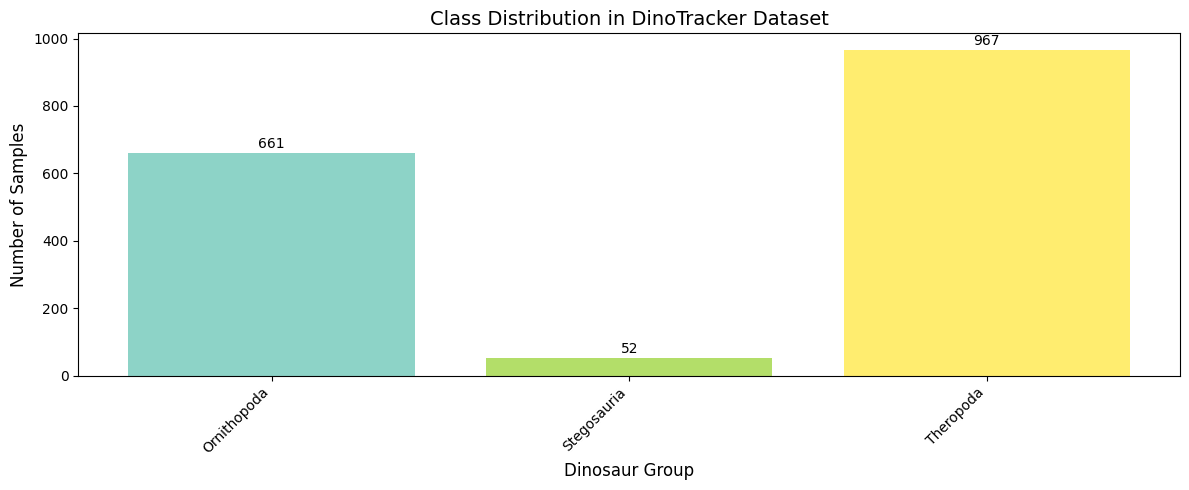

In [18]:
# ============================================
# VISUALIZE CLASS DISTRIBUTION
# ============================================

fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(CLASS_NAMES, counts, color=plt.cm.Set3(np.linspace(0, 1, NUM_CLASSES)))
ax.set_xlabel('Dinosaur Group', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('Class Distribution in DinoTracker Dataset', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add count labels on bars
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'class_distribution.png'), dpi=150)
plt.show()

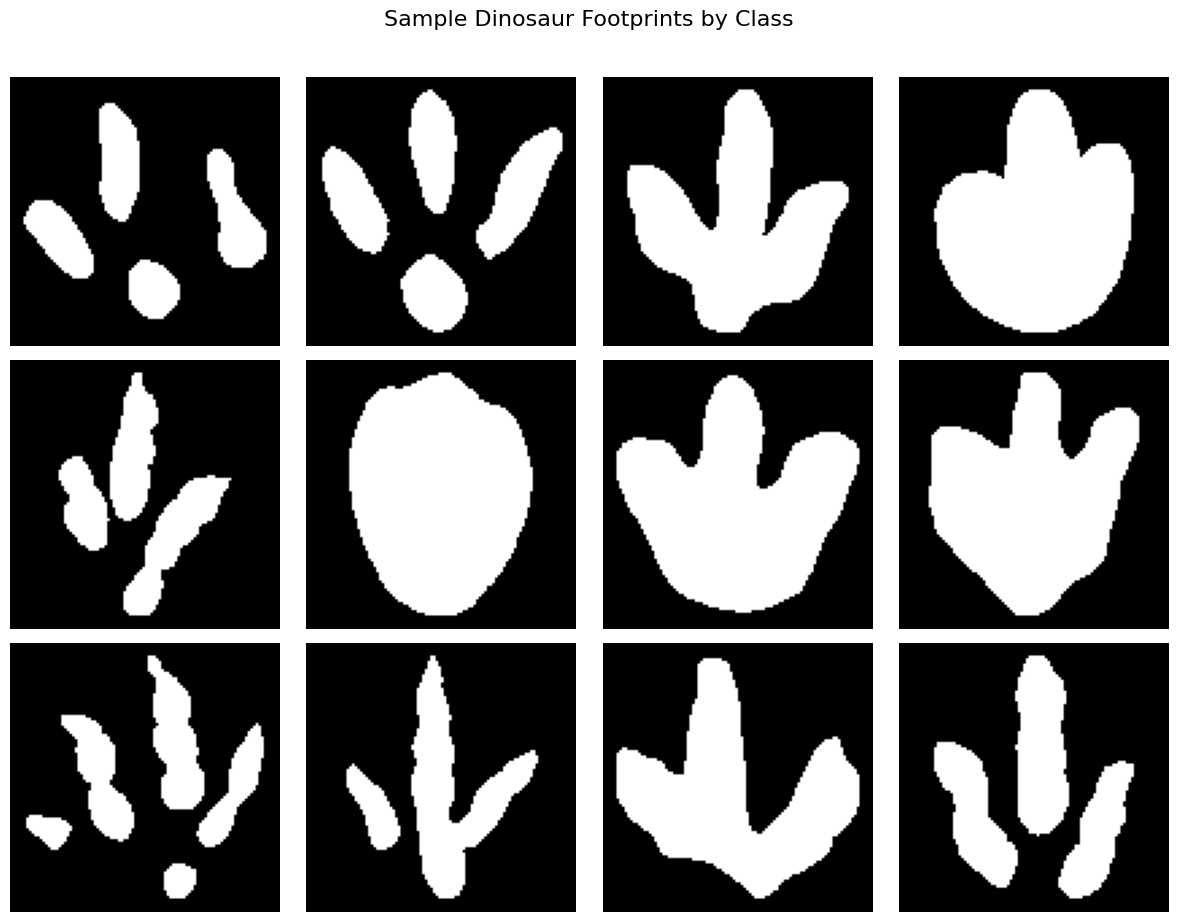

In [19]:
# ============================================
# SHOW SAMPLE IMAGES PER CLASS
# ============================================

fig, axes = plt.subplots(NUM_CLASSES, 4, figsize=(12, 3 * NUM_CLASSES))
fig.suptitle('Sample Dinosaur Footprints by Class', fontsize=16, y=1.02)

for class_idx in range(NUM_CLASSES):
    # Get indices for this class
    class_mask = y_encoded == class_idx
    class_images = X[class_mask]
    
    # Show up to 4 samples
    for j in range(4):
        ax = axes[class_idx, j] if NUM_CLASSES > 1 else axes[j]
        if j < len(class_images):
            ax.imshow(class_images[j].squeeze(), cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.set_ylabel(CLASS_NAMES[class_idx], fontsize=10, rotation=0,
                         labelpad=80, va='center')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'sample_images.png'), dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Data Preprocessing & Split

In [20]:
# ============================================
# TRAIN / VALIDATION / TEST SPLIT
# ============================================

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=TEST_SPLIT, random_state=42, stratify=y_encoded
)

# Second split: separate validation from training
# Calculate validation ratio relative to remaining data
val_ratio = VAL_SPLIT / (1 - TEST_SPLIT)
y_temp_encoded = np.argmax(y_temp, axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_ratio, random_state=42, stratify=y_temp_encoded
)

print(f"{'='*50}")
print(f"DATA SPLIT")
print(f"{'='*50}")
print(f"Training:   {X_train.shape[0]:5d} images ({100*X_train.shape[0]/len(X):.1f}%)")
print(f"Validation: {X_val.shape[0]:5d} images ({100*X_val.shape[0]/len(X):.1f}%)")
print(f"Test:       {X_test.shape[0]:5d} images ({100*X_test.shape[0]/len(X):.1f}%)")
print(f"Total:      {len(X):5d} images")

DATA SPLIT
Training:    1175 images (69.9%)
Validation:   253 images (15.1%)
Test:         252 images (15.0%)
Total:       1680 images


In [21]:
# ============================================
# DATA AUGMENTATION
# ============================================

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# No augmentation for validation/test
val_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

print("Data augmentation configured:")
print("  - Rotation: ±20°")
print("  - Width/Height shift: ±10%")
print("  - Horizontal & Vertical flip")
print("  - Zoom: ±10%")

Data augmentation configured:
  - Rotation: ±20°
  - Width/Height shift: ±10%
  - Horizontal & Vertical flip
  - Zoom: ±10%


---
## 5. Model Building

In [22]:
# ============================================
# BUILD CNN MODEL
# ============================================

def build_model(input_shape, num_classes):
    """Build a CNN for dinosaur footprint classification."""
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Classifier
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Build and compile
model = build_model((IMG_SIZE[0], IMG_SIZE[1], 1), NUM_CLASSES)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\DLV\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 100, 100, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,040,483 (19.23 MB)

 Trainable params: 5,039,523 (19.22 MB)

 Non-trainable params: 960 (3.75 KB)

---
## 6. Training

In [23]:
# ============================================
# CALLBACKS
# ============================================

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        os.path.join(MODEL_DIR, 'dino_best_model.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured:")
print("  - EarlyStopping (patience=10, monitor=val_loss)")
print("  - ModelCheckpoint (save best model)")

Callbacks configured:
  - EarlyStopping (patience=10, monitor=val_loss)
  - ModelCheckpoint (save best model)


In [24]:
# ============================================
# TRAIN THE MODEL
# ============================================

# Calculate steps per epoch
steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

print("="*50)
print("Training complete!")

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5215 - loss: 1.2847
Epoch 1: val_loss improved from None to 0.84975, saving model to c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\Footprint_Classification_Project\just one more thing!\models\dino_best_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5416 - loss: 1.1679 - val_accuracy: 0.7366 - val_loss: 0.8498
Epoch 2/100
 1/36 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6875 - loss: 0.8691

c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\DLV\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.84975
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6875 - loss: 0.8691 - val_accuracy: 0.7679 - val_loss: 0.8502
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6066 - loss: 0.9473
Epoch 3: val_loss did not improve from 0.84975
36/36 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.6063 - loss: 0.9375 - val_accuracy: 0.5670 - val_loss: 0.9931
Epoch 4/100
 1/36 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - accuracy: 0.6562 - loss: 0.8634
Epoch 4: val_loss did not improve from 0.84975
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.6562 - loss: 0.8634 - val_accuracy: 0.5670 - val_loss: 0.9993
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5985 - loss: 0.9122
Epoch 5: val_loss did not improve from 0.84975
36/36 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.6107 - loss: 0.8862 - val_accuracy: 0.5670 - val_loss: 1.2307
Epoch 6/100
 1/36 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7188 - loss: 0.7013
Epoch 6: 

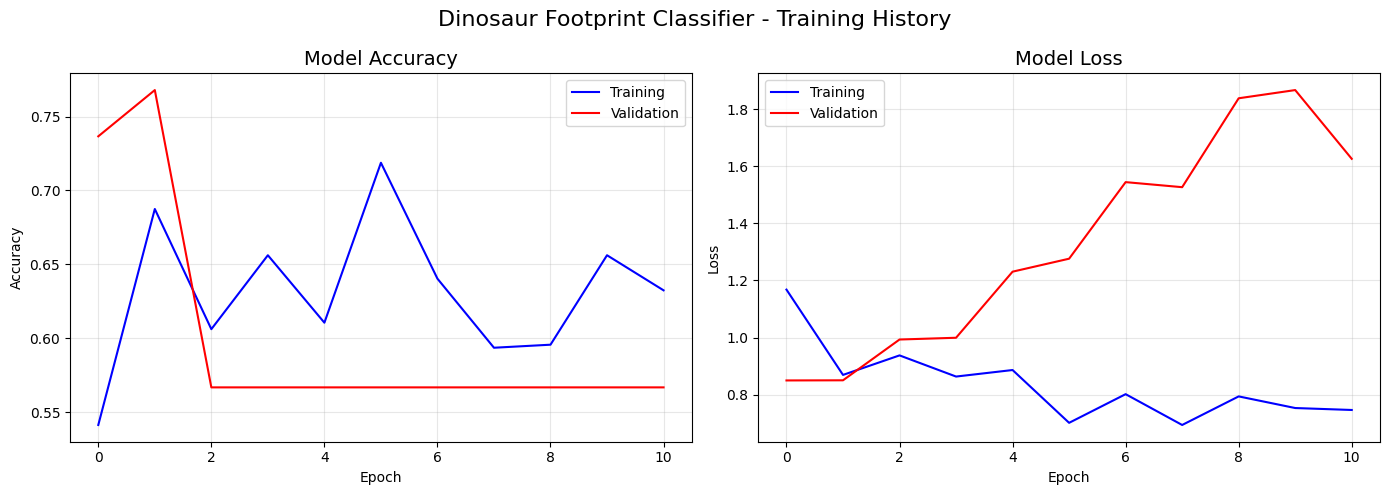

In [25]:
# ============================================
# PLOT TRAINING HISTORY
# ============================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], 'b-', label='Training')
ax1.plot(history.history['val_accuracy'], 'r-', label='Validation')
ax1.set_title('Model Accuracy', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(history.history['loss'], 'b-', label='Training')
ax2.plot(history.history['val_loss'], 'r-', label='Validation')
ax2.set_title('Model Loss', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Dinosaur Footprint Classifier - Training History', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'dino_training_history.png'), dpi=150)
plt.show()

In [26]:
# Save final model
model.save(os.path.join(MODEL_DIR, 'dino_footprint_classifier.keras'))
print(f"Model saved to {MODEL_DIR}/dino_footprint_classifier.keras")

Model saved to c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\Footprint_Classification_Project\just one more thing!\models/dino_footprint_classifier.keras


---
## 7. Evaluation & Results

In [27]:
# ============================================
# EVALUATE ON TEST SET
# ============================================

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"\n{'='*50}")
print(f"TEST RESULTS")
print(f"{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")


TEST RESULTS
Test Loss: 0.8791
Test Accuracy: 68.65%


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step


C:\Users\ayoub\AppData\Local\Temp\ipykernel_6920\1915576835.py:22: UserWarning: Glyph 129429 (\N{SAUROPOD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ayoub\AppData\Local\Temp\ipykernel_6920\1915576835.py:23: UserWarning: Glyph 129429 (\N{SAUROPOD}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(MODEL_DIR, 'dino_confusion_matrix.png'), dpi=150)
c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\DLV\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129429 (\N{SAUROPOD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


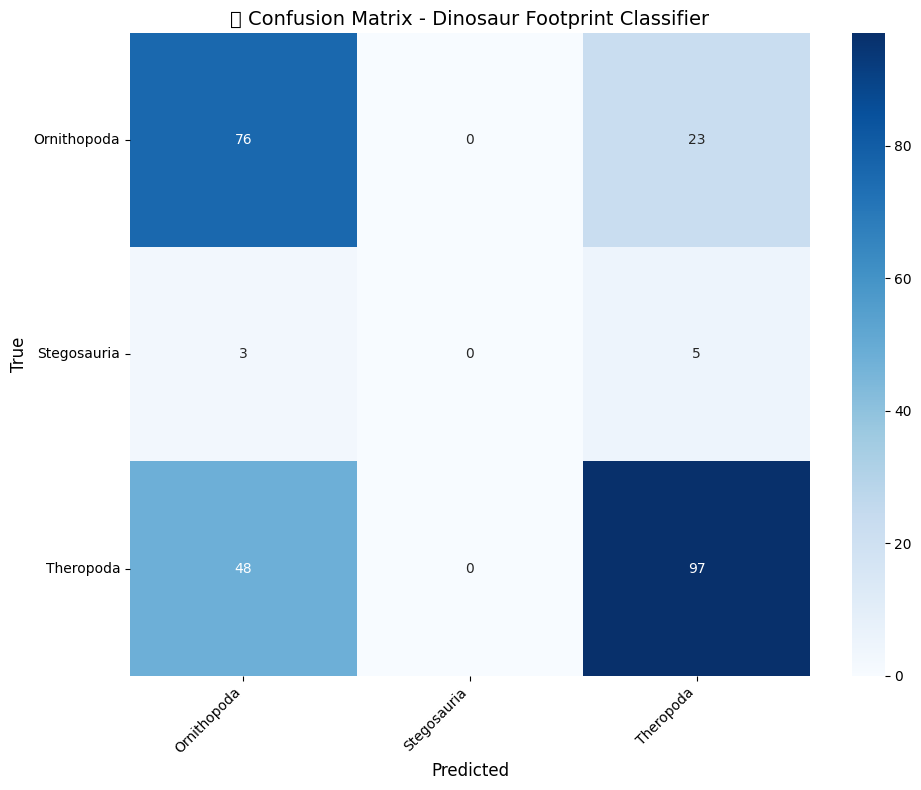

In [28]:
# ============================================
# CONFUSION MATRIX
# ============================================

# Get predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('🦕 Confusion Matrix - Dinosaur Footprint Classifier', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'dino_confusion_matrix.png'), dpi=150)
plt.show()

In [29]:
# ============================================
# CLASSIFICATION REPORT
# ============================================

print("\nCLASSIFICATION REPORT")
print("="*60)
print(classification_report(true_classes, predicted_classes,
                           target_names=CLASS_NAMES))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Ornithopoda       0.60      0.77      0.67        99
 Stegosauria       0.00      0.00      0.00         8
   Theropoda       0.78      0.67      0.72       145

    accuracy                           0.69       252
   macro avg       0.46      0.48      0.46       252
weighted avg       0.68      0.69      0.68       252



c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\DLV\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\DLV\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\DLV\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

C:\Users\ayoub\AppData\Local\Temp\ipykernel_6920\2503426426.py:30: UserWarning: Glyph 129429 (\N{SAUROPOD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ayoub\AppData\Local\Temp\ipykernel_6920\2503426426.py:31: UserWarning: Glyph 129429 (\N{SAUROPOD}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(MODEL_DIR, 'dino_sample_predictions.png'), dpi=150)
c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\DLV\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129429 (\N{SAUROPOD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


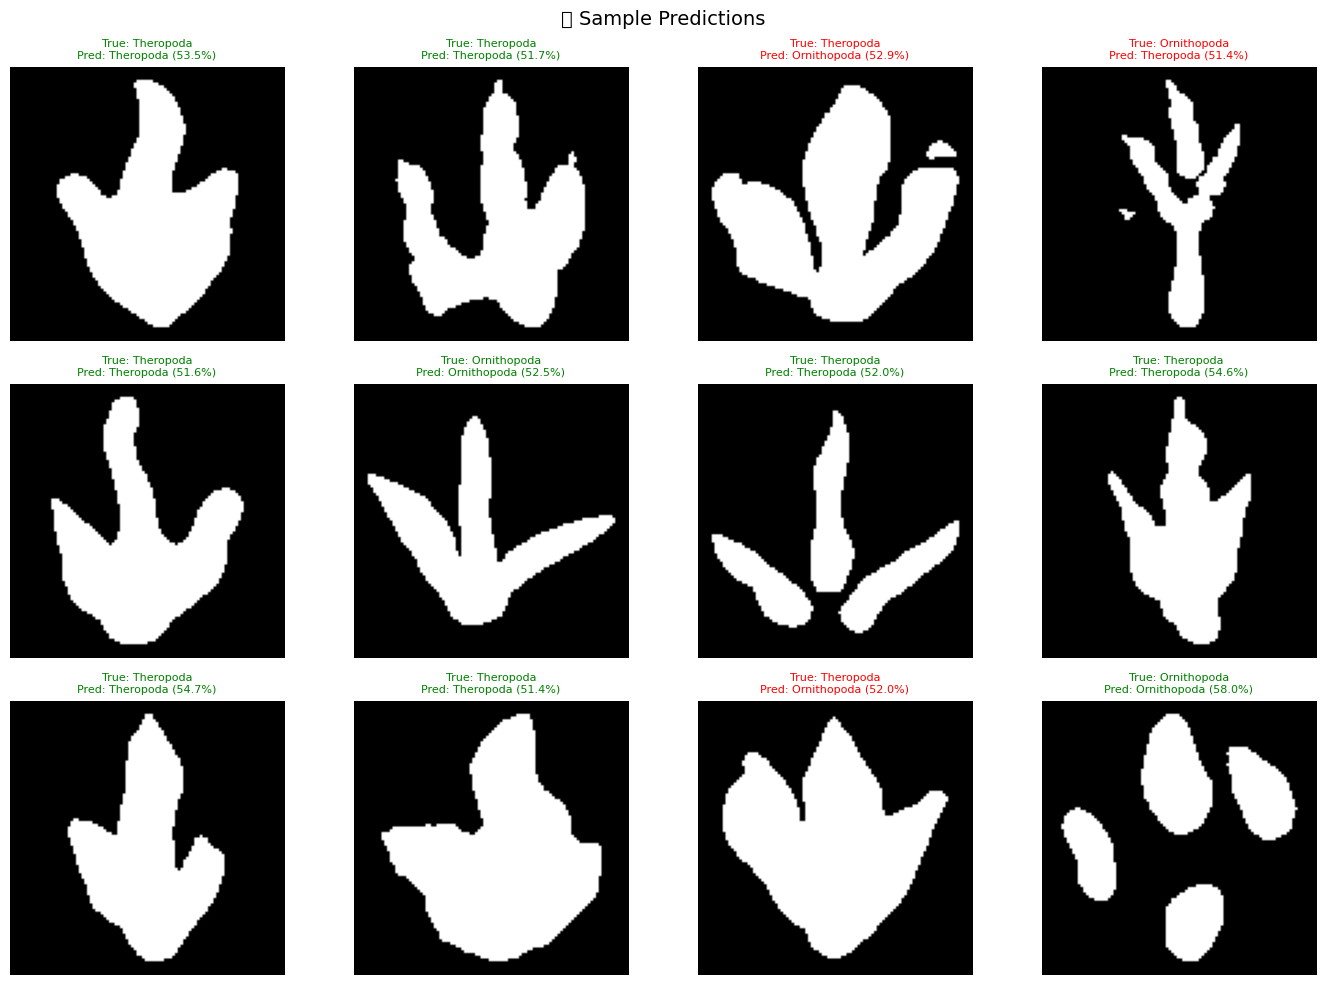

In [30]:
# ============================================
# SAMPLE PREDICTIONS VISUALIZATION
# ============================================

fig, axes = plt.subplots(3, 4, figsize=(14, 10))

# Pick random test samples
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), 12, replace=False)

for i, idx in enumerate(sample_indices):
    row, col = i // 4, i % 4
    ax = axes[row, col]
    
    # Display image
    ax.imshow(X_test[idx].squeeze(), cmap='gray')
    
    # Get prediction info
    true_label = CLASS_NAMES[true_classes[idx]]
    pred_label = CLASS_NAMES[predicted_classes[idx]]
    confidence = predictions[idx][predicted_classes[idx]]
    
    # Color-code: green=correct, red=wrong
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1%})",
                fontsize=8, color=color)
    ax.axis('off')

plt.suptitle('🦕 Sample Predictions', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'dino_sample_predictions.png'), dpi=150)
plt.show()

---
## 📊 Final Summary

In [31]:
print("\n" + "="*60)
print("🦕 FINAL SUMMARY")
print("="*60)
print(f"\n📊 Classes: {NUM_CLASSES}")
print(f"   {CLASS_NAMES}")
print(f"\n🖼️ Data:")
print(f"   Training:   {X_train.shape[0]} images")
print(f"   Validation: {X_val.shape[0]} images")
print(f"   Test:       {X_test.shape[0]} images")
print(f"\n🎯 Test Accuracy: {test_accuracy:.2%}")
print(f"\n💾 Saved files:")
print(f"   - {MODEL_DIR}/dino_best_model.keras")
print(f"   - {MODEL_DIR}/dino_footprint_classifier.keras")
print(f"   - {MODEL_DIR}/dino_training_history.png")
print(f"   - {MODEL_DIR}/dino_confusion_matrix.png")
print(f"   - {MODEL_DIR}/dino_sample_predictions.png")
print(f"   - {MODEL_DIR}/class_distribution.png")
print(f"   - {MODEL_DIR}/sample_images.png")
print("="*60)


🦕 FINAL SUMMARY

📊 Classes: 3
   [np.str_('Ornithopoda'), np.str_('Stegosauria'), np.str_('Theropoda')]

🖼️ Data:
   Training:   1175 images
   Validation: 253 images
   Test:       252 images

🎯 Test Accuracy: 68.65%

💾 Saved files:
   - c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\Footprint_Classification_Project\just one more thing!\models/dino_best_model.keras
   - c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\Footprint_Classification_Project\just one more thing!\models/dino_footprint_classifier.keras
   - c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\Footprint_Classification_Project\just one more thing!\models/dino_training_history.png
   - c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\Footprint_Classification_Project\just one more thing!\models/dino_confusion_matrix.png
   - c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\Footprint_Classification_Project\just one more thing!\models/dino_sample_predictions.png
   - c:\Users\ayoub\Desktop\DL_PROJECT\PROJECT\Footprint_Classification_Project\just one mo

---
## ✅ Pipeline Complete!

**Model architecture:**
```
Input(100,100,1) → [Conv2D(32)×2 + BN + MaxPool + Dropout]
                 → [Conv2D(64)×2 + BN + MaxPool + Dropout]
                 → [Conv2D(128)×2 + BN + MaxPool + Dropout]
                 → Dense(256) + BN + Dropout
                 → Dense(128) + Dropout
                 → Dense(3, softmax)
```

**5 Dinosaur Classes:**
- 🦆 **Ornithopoda** — Duck-billed dinosaurs (Hadrosaurs, Iguanodon)
- 🛡️ **Stegosauria** — Plated dinosaurs (Stegosaurus)
- 🦖 **Theropoda** — Bipedal predators (T-Rex, Velociraptor)

**Data source:** DinoTracker dataset
- Images from `data/images_compressed.npz`
- Labels from `data/tracks.xlsx` (Group column)
- Name mapping via `data/names.npy`